In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input
from keras.utils import plot_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix-1, -2:]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5271_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2),  'SS':data['SS'].ravel(), 'TTF':data['TTF'].ravel()})  
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  

df = a_t.merge(m_t, on='Time')

df = df.drop(['Time'], axis=1)   # Drop irrelevant features
print("Input data: ", df.shape)


Input data:  (75999, 6)


In [4]:
# Preprocessing


arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))


Features shape, X =  (75700, 300, 4)
Target shape, Y =  (75700, 2)
After reshaping, X =  (75700, 1200)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])


Training samples: 54504
Validation samples: 6056
Testing samples: 15140


Epoch 1/10
1704/1704 [==============================] - 15s 9ms/step - loss: 0.0458 - ss_loss: 0.0018 - ttf_loss: 0.0881 - val_loss: 0.0591 - val_ss_loss: 0.0019 - val_ttf_loss: 0.1143
Epoch 2/10
1704/1704 [==============================] - 14s 8ms/step - loss: 0.0374 - ss_loss: 0.0012 - ttf_loss: 0.0723 - val_loss: 0.0638 - val_ss_loss: 0.0019 - val_ttf_loss: 0.1237
Epoch 3/10
1704/1704 [==============================] - 14s 8ms/step - loss: 0.0354 - ss_loss: 0.0012 - ttf_loss: 0.0684 - val_loss: 0.0442 - val_ss_loss: 6.4436e-04 - val_ttf_loss: 0.0871
Epoch 4/10
1704/1704 [==============================] - 14s 8ms/step - loss: 0.0340 - ss_loss: 0.0012 - ttf_loss: 0.0656 - val_loss: 0.0411 - val_ss_loss: 8.4142e-04 - val_ttf_loss: 0.0804
Epoch 5/10
1704/1704 [==============================] - 14s 8ms/step - loss: 0.0330 - ss_loss: 0.0011 - ttf_loss: 0.0639 - val_loss: 0.0475 - val_ss_loss: 8.7439e-04 - val_ttf_loss: 0.0932
Epoch 6/10
1704/1704 [==============================] - 14s 8ms

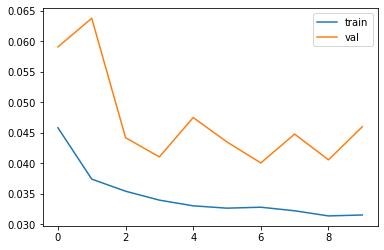

---Training time: 138.43240452 seconds ---


In [6]:

model = load_model('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/MLP_ssttf.h5')

losses = {'ss': 'mse', 'ttf':'mse'}
losswts = {'ss': 1.0, 'ttf': 0.5}
model.compile(loss=losses, loss_weights=losswts, optimizer='adam')

start_time = time.time()
history = model.fit(X_train, {'ss':Y_train[:,0], 'ttf':Y_train[:,1]}, epochs=10, batch_size=32, 
                    validation_data=(X_val, {'ss':Y_val[:,0], 'ttf':Y_val[:,1]}), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [7]:
# Evaluate the model

y_predTrain = model.predict(X_train)
y_predTrain[1] = np.clip(y_predTrain[1].ravel(), a_min=0,a_max=None)
ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[0]))
ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[1]))

y_predVal = model.predict(X_val)
y_predVal[1] = np.clip(y_predVal[1].ravel(), a_min=0,a_max=None)
ss_val_r2 = r2_score(Y_val[:,0], y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[0]))  
ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[1]))

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
y_predTest[1] = np.clip(y_predTest[1].ravel(), a_min=0,a_max=None)
ss_test_r2 = r2_score(y_test[:,0], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[0]))
ttf_test_r2 = r2_score(y_test[:,1], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[1]))

print("Shear Stress\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_r2, ss_val_r2, ss_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_rmse, ss_val_rmse, ss_test_rmse))

print("\nTTF\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_r2, ttf_val_r2, ttf_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_rmse, ttf_val_rmse, ttf_test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


Shear Stress
R2 scores: Train - 0.90564, Validation - 0.93520, Test - 0.80043
RMSE scores: Train - 0.02677, Validation - 0.02830, Test - 0.05535

TTF
R2 scores: Train - 0.93136, Validation - 0.92035, Test - 0.65690
RMSE scores: Train - 0.24836, Validation - 0.30037, Test - 0.67018

---Time for Test data prediction: 1.40554285 seconds ---


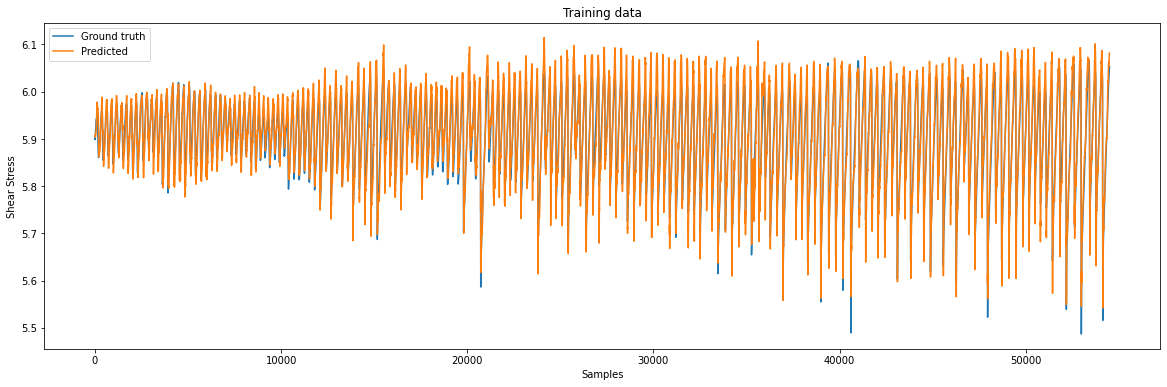

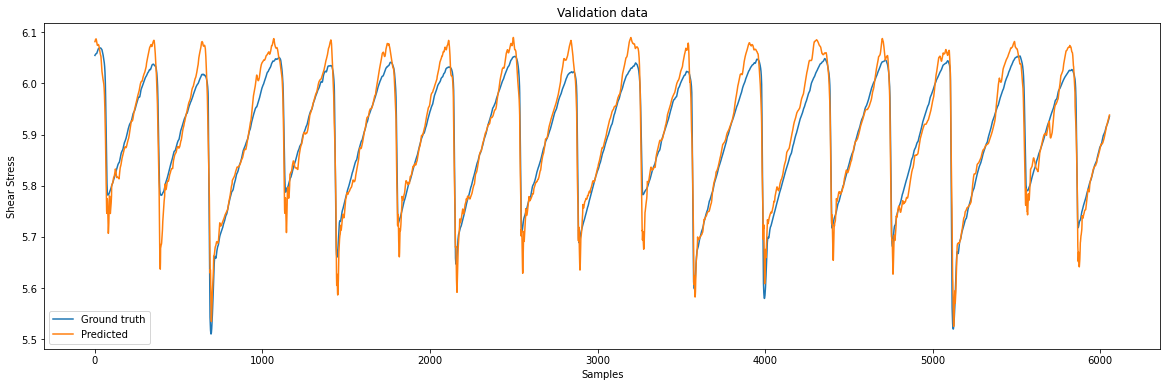

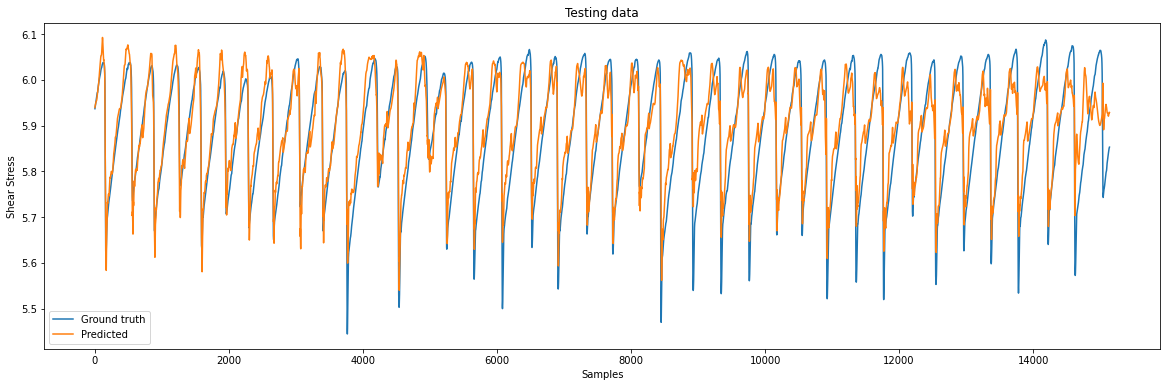

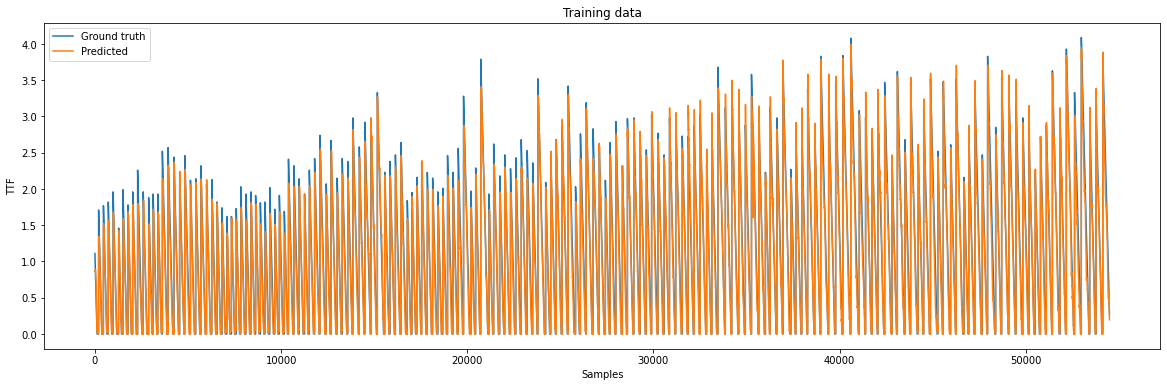

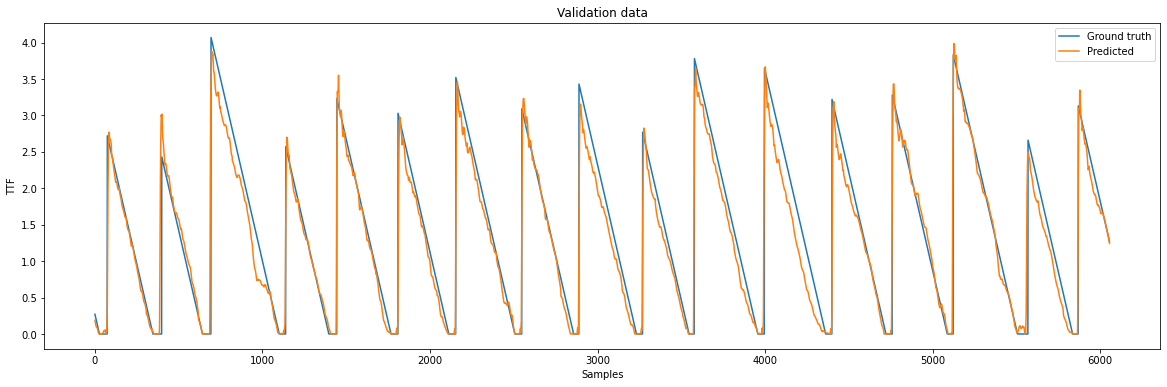

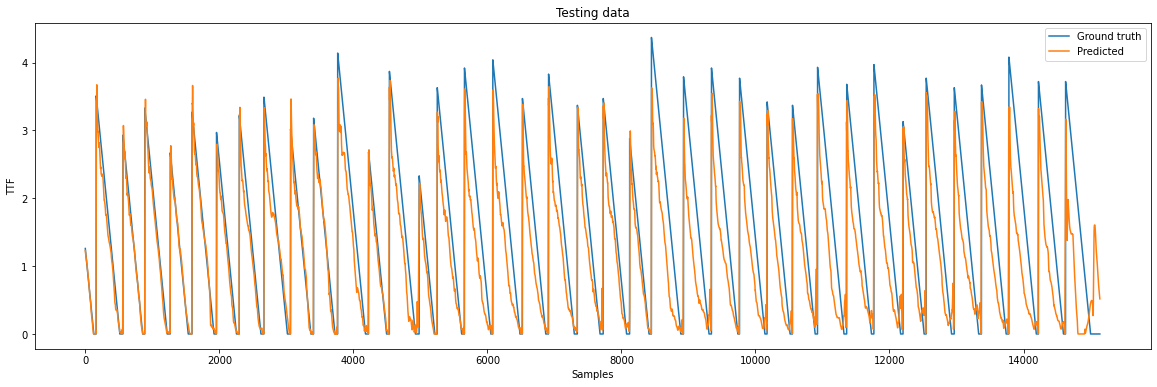

In [8]:
# Results plot

def results_plot(fig_no, gt, pred, title, ylabel):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel(ylabel)
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train[:,0], y_predTrain[0], 'Training data', 'Shear Stress')
results_plot(2, Y_val[:,0], y_predVal[0], 'Validation data', 'Shear Stress')
results_plot(3, y_test[:,0], y_predTest[0], 'Testing data', 'Shear Stress')
results_plot(4, Y_train[:,1], y_predTrain[1], 'Training data', 'TTF')
results_plot(5, Y_val[:,1], y_predVal[1], 'Validation data', 'TTF')
results_plot(6, y_test[:,1], y_predTest[1], 'Testing data', 'TTF')
